In [69]:
import portfolioTheory as pt
import yftickers as ticks
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

In [6]:
tickers = ticks.ftse100
start=dt.datetime(2000,1,1)
end=dt.datetime(2023,1,1)
threshold=0.9

In [23]:
portfolio = pt.Portfolio(tickers, start, end)
portfolio.getData()
portfolio.cleanData(dateRange=['2002','2023'], threshold=threshold)
portfolio.calculate_stats()

[*********************100%***********************]  101 of 101 completed

3 Failed downloads:
- MGGT.L: No timezone found, symbol may be delisted
- RMG.L: No timezone found, symbol may be delisted
- AUTO: No timezone found, symbol may be delisted
33 columns were removed because there were less observations than the threshold (0.9):
AAL       73.20%
ABDN.L    70.15%
AHT       82.06%
AUTO       0.00%
BME       75.34%
BRBY.L    87.60%
CCH.L     41.20%
CPG       81.42%
EDV       63.31%
ENT.L     76.87%
EXPN.L    69.06%
FLTR      49.55%
FRES.L    62.34%
GLEN.L    49.39%
HIK.L     73.07%
HL.L      66.55%
IAG       82.57%
IHG       83.66%
III       67.39%
INVR.L    61.61%
ITRK.L    88.18%
LAND      42.11%
MGGT.L     0.00%
MNDI.L    66.01%
NWG       64.48%
OCDO.L    52.96%
PHNX.L    55.82%
PRU       89.25%
RMG.L      0.00%
RMV.L     71.53%
SKG.L     67.24%
SMIN      46.18%
UTG       79.96%
dtype: object


In [25]:
meanReturns = portfolio.logReturns.mean()
covMatrix = portfolio.covMatrix

In [26]:
maxSR = pt.maxSharpeRatio(meanReturns, covMatrix)

# EDA

In [38]:
print('{} years and {} average days'.format(len(portfolio.logReturns.groupby(portfolio.logReturns.index.year)),round(len(portfolio.logReturns)/len(portfolio.logReturns.groupby(portfolio.logReturns.index.year)),3)))

21 years and 236.952 average days


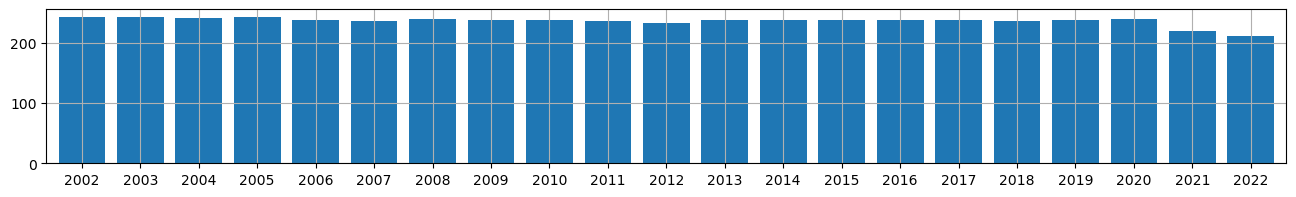

In [58]:
avDays = portfolio.logReturns.groupby(portfolio.logReturns.index.year).count().mean(axis=1)
fig = plt.figure(figsize=(16,2))
plt.bar(avDays.index,avDays.values)
plt.xticks(avDays.index)
plt.margins(x=0.01)
plt.grid()
plt.show()

In [61]:
avDays

Date
2002    243.0
2003    243.0
2004    242.0
2005    244.0
2006    238.0
2007    237.0
2008    240.0
2009    239.0
2010    238.0
2011    237.0
2012    233.0
2013    239.0
2014    239.0
2015    239.0
2016    239.0
2017    238.0
2018    237.0
2019    239.0
2020    240.0
2021    220.0
2022    212.0
dtype: float64

In [71]:
#data_canada = px.data.gapminder().query("country == 'Canada'")
layout = go.Layout(
    title='some title',
    xaxis=dict(
        title='Xaxis Name',
        tickmode='linear')
)
fig = px.bar(x=avDays.index, y=avDays.values, height=300)
fig.show()

In [ ]:
portfolio.calculate_PortPerformance(maxSR[1][1], T=252)

In [24]:
portfolio.logReturns

,ABF.L,ADM,ANTO.L,AON,AV.L,AVV.L,AZN,BA.L,BARC.L,BATS.L,...,STAN.L,STJ.L,SVT,TSCO,TW.L,ULVR.L,UU.L,VOD,WPP,WTB.L
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-03,0.016277,-0.010642,-0.004764,0.001970,0.007067,0.000000,-0.001747,0.003180,0.010103,-0.007776,...,0.016647,0.010094,0.000000,0.042462,-0.010007,-0.007067,0.016532,0.028889,0.006810,0.000000
2002-01-04,0.003023,-0.037795,0.002861,-0.000281,-0.009434,0.016845,-0.014753,0.013558,0.006100,-0.022808,...,0.005879,0.008571,0.000000,0.024967,0.042200,-0.010696,0.000000,-0.002626,0.049733,0.044851
2002-01-07,-0.005043,-0.005199,0.011364,-0.011597,-0.007134,0.022027,-0.007347,0.000000,-0.012238,0.000887,...,0.001172,0.009908,0.000000,-0.005770,0.002751,-0.009001,0.004090,-0.031288,0.004528,0.004376
2002-01-08,0.001011,0.022092,0.002821,-0.008572,-0.010195,-0.030976,-0.011462,0.008421,-0.004408,-0.002663,...,-0.004695,-0.028573,0.043059,0.019376,-0.033523,-0.006349,0.000000,-0.013659,-0.023556,-0.009654
2002-01-09,-0.010153,0.002909,0.006551,0.002293,-0.017635,-0.022728,0.013248,0.012346,0.011419,0.009730,...,-0.001177,-0.007273,0.000000,-0.011143,0.011300,0.006349,-0.017294,-0.069133,-0.029239,0.018349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-21,0.021161,0.014209,0.026642,0.017376,0.019100,0.001557,0.002654,0.010750,0.014913,0.011698,...,0.007378,0.032549,-0.023311,0.019084,0.030936,0.016346,0.007890,0.005923,0.022619,0.017068
2022-12-22,-0.004770,-0.008308,-0.014858,-0.009549,-0.007372,-0.000934,0.002648,0.001394,-0.005964,0.006180,...,-0.001279,-0.019586,0.000000,-0.005617,-0.004389,-0.002844,-0.012674,-0.007905,-0.007686,-0.010206
2022-12-23,0.011726,0.012014,0.004869,0.001465,-0.004494,0.003110,-0.001470,-0.007690,0.003811,-0.000904,...,0.000000,0.003673,0.064833,0.018647,0.008275,0.000237,-0.003440,0.003960,0.007686,-0.003044


In [22]:
# Years in the series
num_years = len(portfolio.portReturns.groupby(portfolio.portReturns.index.year)),
# average days in a year
num_days = int(len(portfolio.portReturns)/len(portfolio.portReturns.groupby(portfolio.portReturns.index.year)))
num_years, num_days

AttributeError: 'Portfolio' object has no attribute 'portReturns'